[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/khetansarvesh/CV/blob/main/data_augmentation/ddpm/dit_runner.ipynb)

In [ ]:
import torch
import yaml
import argparse
import os
import numpy as np
from tqdm import tqdm
import glob
import cv2
from PIL import Image
from einops import rearrange, repeat

import torch
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim import Adam, AdamW
from torch.utils.data.dataset import Dataset
from torchvision.utils import make_grid

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.backends.mps.is_available():
    device = torch.device('mps')
    print('Using mps')

# **Dataset**

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader

In [ ]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]) # Define the transformation to normalize the data between 1 and -1 (mean = 0.5 and variance = 0.5 will transform to values between 1 and -1)
mnist = datasets.MNIST(root='./data', train=True, transform=transform, download=True) # downloading the MNIST train dataset and then applying some transformations
data_loader = DataLoader(dataset=mnist, batch_size=32, shuffle=True) # loading the downloaded dataset

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 11.6MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 345kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 3.23MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.52MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# **Modelling**

In [ ]:
def get_time_embedding(time_steps, # 1D array of timesteps eg [1,10,500,40,300]
                       temb_dim): # dimension of vector to which each of these timestep needs to be converted to eg 128

    # factor = 10000^(2i/d_model)
    factor = 10000 ** ((torch.arange(start=0, end=temb_dim // 2, dtype=torch.float32, device=time_steps.device) / (temb_dim // 2)))

    # pos / factor
    t_emb = time_steps[:, None].repeat(1, temb_dim // 2) / factor

    # now taking sin and cos of t_emb
    return torch.cat([torch.sin(t_emb), torch.cos(t_emb)], dim=-1)

In [ ]:
class DIT(nn.Module):

    def __init__(self):
        super().__init__()

        self.patch_embedding = nn.Sequential(nn.LayerNorm(1*4*4), nn.Linear(1*4*4, 768), nn.LayerNorm(768))
        self.position_embedding = nn.Parameter(data=torch.randn(1, 49, 768),requires_grad=True)
        self.embedding_dropout = nn.Dropout(p=0.1)

        self.transformer_encoder = nn.TransformerEncoder(encoder_layer=nn.TransformerEncoderLayer(d_model=768,
                                                                                                  nhead=2,
                                                                                                  dim_feedforward=3072,
                                                                                                  activation="gelu",
                                                                                                  batch_first=True,
                                                                                                  norm_first=True), # Create a single Transformer Encoder Layer
                                                        num_layers=2) # Stack it N times

        # Final Linear Layer
        self.proj_out = nn.Linear(768, 1*4*4)

        # Time projection
        self.ti_1 = nn.Linear(128, 400)
        self.ti_2 = nn.Linear(400, 768)

    def forward(self, x, t):

        # getting time embeddings
        t_emb = get_time_embedding(torch.as_tensor(t).long(), 128)

        # projecting time embeddings to D = 768 dimensions
        time_proj1 = self.ti_1(t_emb)
        time_proj2 = self.ti_2(time_proj1)

        # Reshaping time embedding [32, 768, 1, 1] => [32, 768] => [32, 1, 768]
        t_reshaped = time_proj2.squeeze(-2).squeeze(-1)
        t_reshaped = t_reshaped.unsqueeze(1)


        # 32, 1, 28, 28 -> 32, 1, 7*4, 7*4 -> 32, 1, 7, 7, 4, 4 -> 32, 7, 7, 4, 4, 1 -> 32, 7*7, 4*4*1 - > 32, num_patches, patch_dim
        x = rearrange(x, 'b c (nh ph) (nw pw) -> b (nh nw) (ph pw c)', ph=4, pw=4)

        # Create patch embedding for all images in the batch
        x = self.patch_embedding(x)

        #Add position embedding to patch embedding
        x = self.position_embedding + x

        # concatenating time embedding
        x = torch.cat([x, t_reshaped], dim=1)

        #Run embedding dropout
        x = self.embedding_dropout(x)

        #Pass patch, position and class embedding through transformer encoder layers (equations 2 & 3)
        x = self.transformer_encoder(x)

        # Unpatchify i.e. (B,patches,hidden_size) -> (B,patches,channels * patch_width * patch_height)
        x = self.proj_out(x[:, 1:]) # note here we are ignore the first vector which represents the matured time embedding

        # combine all the patches to form image
        x = rearrange(x, 'b (nh nw) (ph pw c) -> b c (nh ph) (nw pw)',ph=4,pw=4,nw=7,nh=7)
        return x

In [ ]:
model = DIT().to(device)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


# **Training**

In [ ]:
batch_size = 64
num_samples = 100
num_grid_rows = 10

model.train()
optimizer = Adam(model.parameters(), lr = 0.0001)

betas = torch.linspace(0.0001, 0.02, 1000).to(device) # creating a linear beta schedule for all the timestamps
alpha_cum_prod = torch.cumprod(1. - betas, dim=0).to(device) # calculating alpha_bar for each timestamp
sqrt_alpha_cum_prod = torch.sqrt(alpha_cum_prod).to(device) # calculating sqrt(alpha_bar) for each timestamp
sqrt_one_minus_alpha_cum_prod = torch.sqrt(1 - alpha_cum_prod).to(device) # calculating sqrt(1-alpha_bar) for each timestamp

In [ ]:
if os.path.exists(os.path.join('mnist', 'dit_ckpt.pth')):
    model.load_state_dict(torch.load(os.path.join('mnist_dit_ckpt.pth'), map_location=device))

In [ ]:
for epoch in range(40): # running for 40 epochs
  losses = []

  for im,_ in tqdm(data_loader):
    optimizer.zero_grad()

    im = im.float().to(device)
    noise = torch.randn_like(im).to(device) # sample random noise
    t = torch.randint(low = 0, high = 1000, size = (im.shape[0],)).to(device) # sample a random timestamp for each image in the batch
    noisy_im = torch.sqrt(alpha_cum_prod[t])[:, None, None, None].to(device) * im + torch.sqrt(1 - alpha_cum_prod[t])[:, None, None, None].to(device) * noise # add noise to image according to the timestamp
    noise_pred = model(noisy_im, t) # predicting the added noise

    loss = torch.nn.MSELoss()(noise_pred, noise) # loss fucntion
    losses.append(loss.item())
    loss.backward() # backpropagating the loss
    optimizer.step()

  print(f'Finished epoch:{epoch+1} | Loss : {np.mean(losses)}')
  torch.save(model.state_dict(), os.path.join('mnist_dit_ckpt.pth'))
  print()

100%|██████████| 1875/1875 [01:25<00:00, 22.00it/s]


Finished epoch:1 | Loss : 0.18668846496740976



100%|██████████| 1875/1875 [01:35<00:00, 19.70it/s]


Finished epoch:2 | Loss : 0.1623677982211113



100%|██████████| 1875/1875 [01:35<00:00, 19.72it/s]


Finished epoch:3 | Loss : 0.15505246757268906



100%|██████████| 1875/1875 [01:34<00:00, 19.75it/s]


Finished epoch:4 | Loss : 0.15150048408508301



100%|██████████| 1875/1875 [01:34<00:00, 19.77it/s]


Finished epoch:5 | Loss : 0.1496617052356402



100%|██████████| 1875/1875 [01:34<00:00, 19.76it/s]


Finished epoch:6 | Loss : 0.14751106660763422



100%|██████████| 1875/1875 [01:34<00:00, 19.75it/s]


Finished epoch:7 | Loss : 0.1469119545618693



100%|██████████| 1875/1875 [01:34<00:00, 19.76it/s]


Finished epoch:8 | Loss : 0.14540057069857915



100%|██████████| 1875/1875 [01:34<00:00, 19.76it/s]


Finished epoch:9 | Loss : 0.14458366389274596



100%|██████████| 1875/1875 [01:34<00:00, 19.76it/s]


Finished epoch:10 | Loss : 0.14331739673614502



100%|██████████| 1875/1875 [01:34<00:00, 19.75it/s]


Finished epoch:11 | Loss : 0.14310169281959534



100%|██████████| 1875/1875 [01:34<00:00, 19.76it/s]


Finished epoch:12 | Loss : 0.14262234828472137



100%|██████████| 1875/1875 [01:34<00:00, 19.76it/s]


Finished epoch:13 | Loss : 0.14195348973671595



100%|██████████| 1875/1875 [01:34<00:00, 19.77it/s]


Finished epoch:14 | Loss : 0.14202962133487065



100%|██████████| 1875/1875 [01:34<00:00, 19.76it/s]


Finished epoch:15 | Loss : 0.1417269180615743



100%|██████████| 1875/1875 [01:34<00:00, 19.76it/s]


Finished epoch:16 | Loss : 0.14133298392693203



100%|██████████| 1875/1875 [01:34<00:00, 19.77it/s]


Finished epoch:17 | Loss : 0.14071684466997783



100%|██████████| 1875/1875 [01:34<00:00, 19.76it/s]


Finished epoch:18 | Loss : 0.14056504458586375



100%|██████████| 1875/1875 [01:34<00:00, 19.76it/s]


Finished epoch:19 | Loss : 0.14056689273516337



100%|██████████| 1875/1875 [01:34<00:00, 19.77it/s]


Finished epoch:20 | Loss : 0.14034327607949576



100%|██████████| 1875/1875 [01:34<00:00, 19.76it/s]


Finished epoch:21 | Loss : 0.1400619794646899



100%|██████████| 1875/1875 [01:34<00:00, 19.77it/s]


Finished epoch:22 | Loss : 0.1395357098142306



100%|██████████| 1875/1875 [01:34<00:00, 19.76it/s]


Finished epoch:23 | Loss : 0.13935644256273905



100%|██████████| 1875/1875 [01:34<00:00, 19.77it/s]


Finished epoch:24 | Loss : 0.13914594089984894



100%|██████████| 1875/1875 [01:34<00:00, 19.76it/s]


Finished epoch:25 | Loss : 0.13920483415921528



100%|██████████| 1875/1875 [01:34<00:00, 19.75it/s]


Finished epoch:26 | Loss : 0.1391830184141795



100%|██████████| 1875/1875 [01:34<00:00, 19.75it/s]


Finished epoch:27 | Loss : 0.1390872057557106



100%|██████████| 1875/1875 [01:34<00:00, 19.75it/s]


Finished epoch:28 | Loss : 0.13900496448278427



100%|██████████| 1875/1875 [01:34<00:00, 19.75it/s]


Finished epoch:29 | Loss : 0.13870080661773682



100%|██████████| 1875/1875 [01:34<00:00, 19.74it/s]


Finished epoch:30 | Loss : 0.13856821460723878



100%|██████████| 1875/1875 [01:34<00:00, 19.74it/s]


Finished epoch:31 | Loss : 0.13882257795333863



100%|██████████| 1875/1875 [01:35<00:00, 19.73it/s]


Finished epoch:32 | Loss : 0.13827122107744216



100%|██████████| 1875/1875 [01:34<00:00, 19.76it/s]


Finished epoch:33 | Loss : 0.1380255638082822



100%|██████████| 1875/1875 [01:34<00:00, 19.77it/s]


Finished epoch:34 | Loss : 0.13841141992410025



100%|██████████| 1875/1875 [01:34<00:00, 19.75it/s]


Finished epoch:35 | Loss : 0.13823167454799015



100%|██████████| 1875/1875 [01:34<00:00, 19.76it/s]


Finished epoch:36 | Loss : 0.13780289904673895



100%|██████████| 1875/1875 [01:34<00:00, 19.74it/s]


Finished epoch:37 | Loss : 0.1379167237639427



100%|██████████| 1875/1875 [01:34<00:00, 19.77it/s]


Finished epoch:38 | Loss : 0.1375238690217336



100%|██████████| 1875/1875 [01:34<00:00, 19.76it/s]


Finished epoch:39 | Loss : 0.13772172602415084



100%|██████████| 1875/1875 [01:34<00:00, 19.75it/s]

Finished epoch:40 | Loss : 0.13778865321477254



# **Inference**

In [ ]:
model.eval()

DIT(
  (patch_embedding): Sequential(
    (0): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
    (1): Linear(in_features=16, out_features=768, bias=True)
    (2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (embedding_dropout): Dropout(p=0.1, inplace=False)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (linear1): Linear(in_features=768, out_features=3072, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=3072, out_features=768, bias=True)
        (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )


In [ ]:
with torch.no_grad():
    # creating a random noise sample based on number of images requested to generate
    xt = torch.randn((num_samples, im_channels, im_size, im_size)).to(device)
    for i in tqdm(reversed(range(1000))):

        t = torch.as_tensor(i)
        noise_pred = model(xt, t.unsqueeze(0).to(device)) # Get prediction of noise

        # timestep
        t = t.to(device)

        # calculating Xt-1 using the derived formula
        mean = (xt - ((betas[t])*noise_pred)/(sqrt_one_minus_alpha_cum_prod[t])) / torch.sqrt(1. - betas[t])
        variance = ( (1-alpha_cum_prod[t-1]) / (1.0 - alpha_cum_prod[t]) ) * betas[t]
        sigma = variance ** 0.5 if t != 0 else 0
        xt = mean + sigma * torch.randn(xt.shape).to(xt.device)

        # Save x0
        ims = torch.clamp(xt, -1., 1.).detach().cpu()
        ims = 0.5*ims + 0.5
        grid = make_grid(ims, nrow= num_grid_rows)

        # predicted image
        img = torchvision.transforms.ToPILImage()(grid)

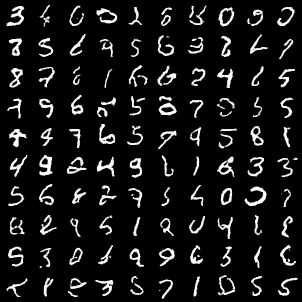

In [ ]:
img